In [18]:
import os
import requests
import numpy as np
from PIL import Image
import cv2 as cv
from matplotlib import pyplot as plt
import argparse

def objectDetect(image):
    yolo_config='yolov3.cfg'
    if not os.path.isfile(yolo_config):
        url='https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg'
        r=requests.get(url)
        with open(yolo_config,'wb') as f:
            f.write(r.content)
    yolo_weights = 'yolov3.weights'
    if not os.path.isfile(yolo_weights):
        url = 'https://pjreddie.com/media/files/yolov3.weights'
        r = requests.get(url)
        with open(yolo_weights, 'wb') as f:
            f.write(r.content)        
    classes_file='coco.names'
    if not os.path.isfile(classes_file):
        url='https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names'
        r=requests.get(url)
        with open(classes_file,'wb') as f:
            f.write(r.content)

    with open(classes_file,'r') as f:
        classes=[line.strip() for line in f.readlines()]

   
    blob = cv.dnn.blobFromImage(image, 1/255, (416,416), (0,0,0), True, crop=False)
    net = cv.dnn.readNet(yolo_weights, yolo_config)
    net.setInput(blob)
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0]-1] for i in net.getUnconnectedOutLayers()]
    outs = net.forward(output_layers)
    class_ids = list()
    confidences = list()
    boxes = list()

    print('outs: ', len(outs))
    for out in outs:
        print(out.shape)
        # iterate over anchor boxes for human class
        for detection in out:
            #bounding box
            center_x = int(detection[0] * image.shape[1])
            center_y = int(detection[1] * image.shape[0])
            w = int(detection[2] * image.shape[1])
            h = int(detection[3] * image.shape[0])
            x = center_x - w // 2
            y = center_y - h // 2
            boxes.append([x,y,w,h])
            #class
            class_id = np.argmax(detection[5:])
            class_ids.append(class_id)
            confidence = detection[4]
            confidences.append(float(confidence))
    #non-max supression
    ids = cv.dnn.NMSBoxes(boxes,confidences,score_threshold=0.3,nms_threshold=0.3)
    #draw the bounding boxes on the image
    colors = np.random.uniform(0,255,size=(len([1]),3))
    print(ids)
    for i in ids:
        i = i[0]
        x,y,w,h = boxes[i]
        class_id = class_ids[i]
        color = colors[0]
        cv.rectangle(image,(round(x),round(y)),(round(x+w),round(y+h)),color,2)
        label = "%s:%.2f"%(classes[class_id], confidences[i])
        cv.putText(image,label,(x-10,y-10),cv.FONT_HERSHEY_SIMPLEX,1,color,2)
        print(label)
        showImg(image)
    
    return (x, y, w, h)

def showImg(img):
  plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
  plt.show()

def hisEqulColor(img):
    ycrcb=cv.cvtColor(img,cv.COLOR_BGR2YCR_CB)
    channels=cv.split(ycrcb)
    print(len(channels))
    cv.equalizeHist(channels[0],channels[0])
    cv.merge(channels,ycrcb)
    cv.cvtColor(ycrcb,cv.COLOR_YCR_CB2BGR,img)
    return img

def dilate(img):
  kernel = cv.getStructuringElement(cv.MORPH_CROSS, (3,3))
  img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
  img = cv.dilate(img, kernel, iterations=1)
  return img

def performDfsCorrection(img, i, j):
  r = img.shape[0]
  c = img.shape[1]

  if (i < 0) or (i >= r) or (j < 0) or (j >= c):
    return False
  
  if img[i][j][0] == 255 or img[i][j][0] == 100 or img[i][j][0] == 200:
    return True

  # value = 0
  img[i][j][0] = 100
  left = performDfsCorrection(img, i, j-1)
  right = performDfsCorrection(img, i, j+1)
  up = performDfsCorrection(img, i-1, j)
  down = performDfsCorrection(img, i+1, j)
  t1 = performDfsCorrection(img, i-1, j+1)
  t2 = performDfsCorrection(img, i+1, j+1)
  t3 = performDfsCorrection(img, i+1, j-1)
  t4 = performDfsCorrection(img, i-1, j-1)

  if left and right and up and down and t1 and t2 and t3 and t4:
    img[i][j][0], img[i][j][1], img[i][j][2] = 200, 200, 200
    return True

  return False


def performSegmentation(img, imgname, rect=None):
  mask = np.zeros(img.shape[:2], np.uint8)

  bgmodel = np.zeros((1,65), np.float64)
  fgmodel = np.zeros((1,65), np.float64)

  #x, y, w, h
  if rect == None:
    rect = (40, 50, 280, 250)
    #rect = (20, 15, 350, 220)
    #rect = (50, 10, 300, 200)
    
  imgrect = img.copy()
  imgrect = cv.rectangle(imgrect, (rect[0],rect[1]), (rect[0] + rect[2],rect[1] + rect[3]), (255, 0, 0), 3)
  showImg(imgrect)

  cv.grabCut(img, mask, rect, bgmodel, fgmodel, 9, cv.GC_INIT_WITH_RECT)

  mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
  img = img * mask2[:, :, np.newaxis]
  for e in img:
    for ee in e:
      if ee[0] == 0 or ee[1] == 0 or ee[2] == 0 :
        ee[0], ee[1], ee[2] = 0, 0, 0
      else:
        ee[0], ee[1], ee[2] = 255, 255, 255
  
  #for i in range(img.shape[0]):
    #for j in range(img.shape[1]):
      #performDfsCorrection(img, i, j)

  showImg(img)
  cv.imwrite(imgname[:-4] + '_seg.png', img)

(300, 400, 3)
outs:  3
(507, 85)
(2028, 85)
(8112, 85)
[[290]]
cow:1.00


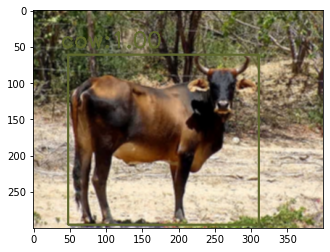

(300, 400, 3)


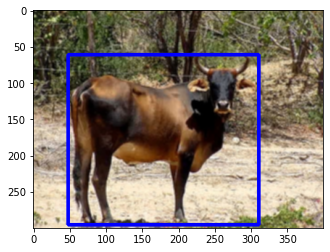

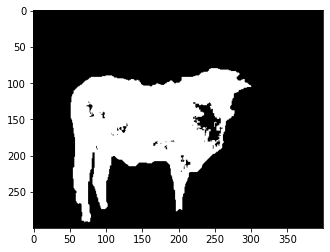

(267, 400, 3)
outs:  3
(507, 85)
(2028, 85)
(8112, 85)
[[254]]
person:1.00


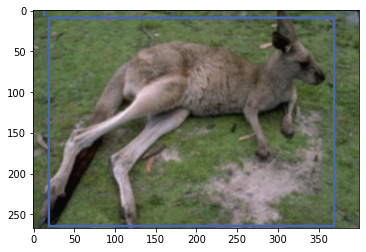

(267, 400, 3)


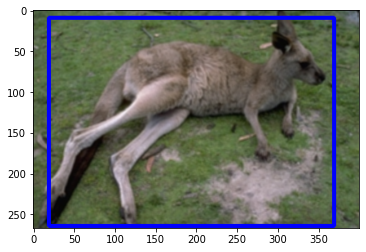

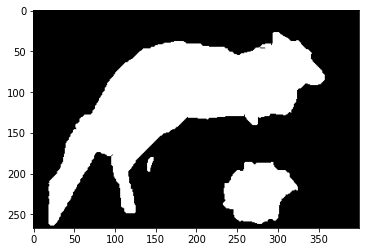

In [44]:
import sys
sys.setrecursionlimit(15000)

def getImage(imgname):

  imgpath = '/content/' + imgname
  img = cv.imread(imgpath) 
  img = cv.GaussianBlur(img, (3, 3), 9)
  #img = cv.resize(img, (100,100)) 
  print(img.shape)
  return img

# take few samples and generate segmentation
imagenames = ['Image1.jpg', 'Image2.jpg']
for imgname in imagenames:
  rect = objectDetect(getImage(imgname))
  performSegmentation(getImage(imgname), imgname, rect)

(300, 400, 3) (300, 400, 3) [  0 255] [  0 255]
Generated segmentation


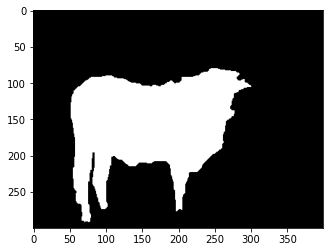

Ground truth


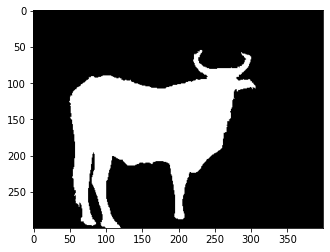

Dice value:  0.9598307940984283


In [51]:
# check dice coefficient
imgtest = cv.imread('/content/Image1_seg.png')
imggt = cv.imread('/content/Image1_GT.png')

print(imggt.shape, imgtest.shape, np.unique(imggt), np.unique(imgtest))
print('Generated segmentation')
showImg(imgtest)
print('Ground truth')
showImg(imggt)

dice = np.sum(imgtest[imggt==255])*2.0 / (np.sum(imgtest) + np.sum(imggt))

print('Dice value: ', dice)